<a href="https://colab.research.google.com/github/spaditha/AI/blob/main/NeMo_Demo_for_voice_swap_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Voice swap application
This notebook will swap a voice in the audio fragment with a computer generated one.

At its core the demo does: 

* Automatic speech recognition of what is said in the file. E.g. converting audio to text
* Adding punctuation and capitalization to the text
* Generating spectrogram from resulting text
* Generating waveform audio from the spectrogram.

## Installation
NeMo can be installed via simple pip command.

In [ ]:
!pip install tf-estimator-nightly==2.8.0.dev2021122109

     |████████████████████████████████| 462 kB 30.1 MB/s 


In [ ]:
!pip install folium==0.2.1

     |████████████████████████████████| 69 kB 7.0 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=69dc373332ed571113712ebe373356d14cdb19785ebd8856783e12b55136e6a5
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


In [ ]:
BRANCH = 'r1.8.2'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]


  Cloning https://github.com/NVIDIA/NeMo.git (to revision r1.8.2) to /tmp/pip-install-qtonr07z/nemo-toolkit_e8f765a46fb945659e636a35fa29e078
  Running command git clone -q https://github.com/NVIDIA/NeMo.git /tmp/pip-install-qtonr07z/nemo-toolkit_e8f765a46fb945659e636a35fa29e078
  Running command git checkout -b r1.8.2 --track origin/r1.8.2
  Switched to a new branch 'r1.8.2'
  Branch 'r1.8.2' set up to track remote branch 'r1.8.2' from 'origin'.
     |████████████████████████████████| 952 kB 30.5 MB/s 
     |████████████████████████████████| 12.8 MB 43.8 MB/s 
     |████████████████████████████████| 109 kB 57.3 MB/s 
     |████████████████████████████████| 99 kB 9.9 MB/s 
     |████████████████████████████████| 235 kB 70.4 MB/s 
     |████████████████████████████████| 77 kB 8.8 MB/s 
     |████████████████████████████████| 97 kB 9.1 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
  Using cached pytest_runner-6.0.0-py3-none-any.whl (7.2 kB)
     |██████████████████████████

In [ ]:
import numpy as np

In [ ]:
print(np.version)

<module 'numpy.version' from '/usr/local/lib/python3.7/dist-packages/numpy/version.py'>


In [ ]:
# Ignore pre-production warnings
import warnings
warnings.filterwarnings('ignore')
import nemo
# Import Speech Recognition collection
import nemo.collections.asr as nemo_asr
# Import Natural Language Processing colleciton
import nemo.collections.nlp as nemo_nlp
# Import Speech Synthesis collection
import nemo.collections.tts as nemo_tts
# We'll use this to listen to audio
import IPython

[NeMo W 2022-05-10 22:14:32 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-05-10 22:14:34 experimental:28] Module <class 'nemo.collections.nlp.data.language_modeling.megatron.megatron_batch_samplers.MegatronPretrainingRandomBatchSampler'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [ ]:
# Downloading audio sample which we'll try
# This is a sample from LibriSpeech Dev Clean dataset - the model hasn't seen it before
Audio_sample = '2086-149220-0033.wav'
!wget https://dldata-public.s3.us-east-2.amazonaws.com/2086-149220-0033.wav
# Listen to it
IPython.display.Audio(Audio_sample)

--2022-05-10 22:14:39--  https://dldata-public.s3.us-east-2.amazonaws.com/2086-149220-0033.wav
Resolving dldata-public.s3.us-east-2.amazonaws.com (dldata-public.s3.us-east-2.amazonaws.com)... 3.5.128.19
Connecting to dldata-public.s3.us-east-2.amazonaws.com (dldata-public.s3.us-east-2.amazonaws.com)|3.5.128.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 237964 (232K) [audio/wav]
Saving to: ‘2086-149220-0033.wav’

2086-149220-0033.wa 100%[===================>] 232.39K  --.-KB/s    in 0.04s   

2022-05-10 22:14:39 (6.08 MB/s) - ‘2086-149220-0033.wav’ saved [237964/237964]



## Instantiate pre-trained NeMo models which we'll use
``from_pretrained(...)`` API downloads and initialized model directly from the cloud.

We will load audio_sample and convert it to text with QuartzNet ASR model (an action called transcribe).
To convert text back to audio, we actually need to generate spectrogram with FastPitch first and then convert it to actual audio signal using the HiFiGAN vocoder.

In [ ]:
# Speech Recognition model - QuartzNet
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="stt_en_quartznet15x5").cuda()

# Punctuation and capitalization model
punctuation = nemo_nlp.models.PunctuationCapitalizationModel.from_pretrained(model_name='punctuation_en_distilbert').cuda()

# Spectrogram generator which takes text as an input and produces spectrogram
spectrogram_generator = nemo_tts.models.FastPitchModel.from_pretrained(model_name="tts_en_fastpitch").cuda()

# Vocoder model which takes spectrogram and produces actual audio
vocoder = nemo_tts.models.HifiGanModel.from_pretrained(model_name="tts_hifigan").cuda()

[NeMo I 2022-05-10 22:16:47 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_quartznet15x5/versions/1.0.0rc1/files/stt_en_quartznet15x5.nemo to /root/.cache/torch/NeMo/NeMo_1.8.2/stt_en_quartznet15x5/16661021d16e679bdfd97a2a03944c49/stt_en_quartznet15x5.nemo
[NeMo I 2022-05-10 22:16:52 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-05-10 22:16:53 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: /asr_set_1.2/train/train_{0..1023}.tar
    num_workers: 20
    
[NeMo W 2022-05-10 22:16:53 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
   

[NeMo I 2022-05-10 22:16:53 features:259] PADDING: 16
[NeMo I 2022-05-10 22:16:53 features:276] STFT using torch
[NeMo I 2022-05-10 22:17:07 save_restore_connector:209] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/stt_en_quartznet15x5/16661021d16e679bdfd97a2a03944c49/stt_en_quartznet15x5.nemo.
[NeMo I 2022-05-10 22:17:07 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/punctuation_en_distilbert/versions/1.0.0rc1/files/punctuation_en_distilbert.nemo to /root/.cache/torch/NeMo/NeMo_1.8.2/punctuation_en_distilbert/613c4ee780c6fc158f49d3566cbd6636/punctuation_en_distilbert.nemo
[NeMo I 2022-05-10 22:17:16 common:747] Instantiating model from pre-trained checkpoint
[NeMo I 2022-05-10 22:17:19 tokenizer_utils:130] Getting HuggingFace AutoTokenizer with pretrained_model_name: distilbert-base-uncased, vocab_file: /tmp/tmpdnxr2mc5/tokenizer.vocab_file, merges_files: None, special_tokens_dict: {}, and use_fast: False


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Using eos_token, but it is not set yet.
Using bos_token, but it is not set yet.
[NeMo W 2022-05-10 22:17:19 modelPT:216] You tried to register an artifact under config key=tokenizer.vocab_file but an artifact for it has already been registered.
[NeMo W 2022-05-10 22:17:19 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    use_tarred_dataset: false
    label_info_save_dir: null
    text_file: text_train.txt
    labels_file: labels_train.txt
    tokens_in_batch: null
    max_seq_length: 128
    num_samples: -1
    use_cache: true
    cache_dir: null
    get_label_frequences: false
    verbose: true
    n_jobs: 0
    tar_metadata_file: null
    tar_shuffle_n: 1
    shuffle: true
    drop_last: false
    pin_memory: true
    num_workers: 8
    persistent_workers: true
    ds_item: punct_dataset_complete
    
[NeMo W 2022-05-10 22:17:19 m

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertEncoder: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
-

[NeMo I 2022-05-10 22:17:26 save_restore_connector:209] Model PunctuationCapitalizationModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/punctuation_en_distilbert/613c4ee780c6fc158f49d3566cbd6636/punctuation_en_distilbert.nemo.
[NeMo I 2022-05-10 22:17:26 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_fastpitch/versions/1.8.1/files/tts_en_fastpitch_align.nemo to /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo
[NeMo I 2022-05-10 22:17:34 common:747] Instantiating model from pre-trained checkpoint
[NeMo I 2022-05-10 22:17:34 tokenize_and_classify:88] Creating ClassifyFst grammars.


[NeMo W 2022-05-10 22:17:39 g2ps:85] apply_to_oov_word=None, it means that some of words will remain unchanged if they are not handled by one of rule in self.parse_one_word(). It is useful when you use tokenizer with set of phonemes and chars together, otherwise it can be not.
[NeMo W 2022-05-10 22:17:40 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /ws/LJSpeech/nvidia_ljspeech_train_clean_ngc.json
      sample_rate: 22050
      sup_data_path: /raid/LJSpeech/supplementary
      sup_data_types:
      - align_prior_matrix
      - pitch
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: nu

[NeMo I 2022-05-10 22:17:40 features:259] PADDING: 1
[NeMo I 2022-05-10 22:17:40 features:276] STFT using torch
[NeMo I 2022-05-10 22:17:40 save_restore_connector:209] Model FastPitchModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_fastpitch_align/26d7e09971f1d611e24df90c7a9d9b38/tts_en_fastpitch_align.nemo.
[NeMo I 2022-05-10 22:17:40 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_hifigan/versions/1.0.0rc1/files/tts_hifigan.nemo to /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo
[NeMo I 2022-05-10 22:17:51 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-05-10 22:17:54 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/train_finetune.txt
      min_duration: 0.75
      n_segments: 8192
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 64
      num_workers: 4
    
[NeMo W 2022-05-10 22:17:54 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.MelAudioDataset
      manifest_filepath: /home/fkreuk/data/val_finetune.txt
      min_duration: 3
      n_segments: 66150


[NeMo I 2022-05-10 22:17:54 features:259] PADDING: 0
[NeMo I 2022-05-10 22:17:54 features:276] STFT using torch


[NeMo W 2022-05-10 22:17:54 features:234] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-05-10 22:17:54 features:259] PADDING: 0
[NeMo I 2022-05-10 22:17:54 features:276] STFT using torch
[NeMo I 2022-05-10 22:17:56 save_restore_connector:209] Model HifiGanModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/tts_hifigan/e6da322f0f7e7dcf3f1900a9229a7e69/tts_hifigan.nemo.


## Using the models

In [ ]:
# Convert our audio sample to text
files = [Audio_sample]
raw_text = ''
text = ''
for fname, transcription in zip(files, quartznet.transcribe(paths2audio_files=files)):
  raw_text = transcription

# Add capitalization and punctuation
res = punctuation.add_punctuation_capitalization(queries=[raw_text])
text = res[0]
print(f'\nRaw recognized text: {raw_text}. \nText with capitalization and punctuation: {text}')

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo I 2022-05-10 22:18:28 punctuation_capitalization_model:1055] Using batch size 1 for inference
[NeMo I 2022-05-10 22:18:28 punctuation_capitalization_infer_dataset:91] Max length: 28
[NeMo I 2022-05-10 22:18:28 data_preprocessing:404] Some stats of the lengths of the sequences:
[NeMo I 2022-05-10 22:18:28 data_preprocessing:410] Min: 26 |                  Max: 26 |                  Mean: 26.0 |                  Median: 26.0
[NeMo I 2022-05-10 22:18:28 data_preprocessing:412] 75 percentile: 26.00
[NeMo I 2022-05-10 22:18:28 data_preprocessing:413] 99 percentile: 26.00


100%|██████████| 1/1 [00:00<00:00, 32.76batch/s]


Raw recognized text: well i don't wish to see it any more observed phoebe turning away her eyes it is certainly very likt the old portrait. 
Text with capitalization and punctuation: Well, I don't wish to see it any more, observed Phoebe, turning away her eyes. It is certainly very likt the old portrait.


In [ ]:
print(f'\nRaw recognized text: {raw_text}. \nText with capitalization and punctuation: {text}')


Raw recognized text: well i don't wish to see it any more observed phoebe turning away her eyes it is certainly very likt the old portrait. 
Text with capitalization and punctuation: Well, I don't wish to see it any more, observed Phoebe, turning away her eyes. It is certainly very likt the old portrait.


In [ ]:
# A helper function which combines TTS models to go directly from 
# text to audio
def text_to_audio(text):
  parsed = spectrogram_generator.parse(text)
  spectrogram = spectrogram_generator.generate_spectrogram(tokens=parsed)
  audio = vocoder.convert_spectrogram_to_audio(spec=spectrogram)
  return audio.to('cpu').detach().numpy()

## Results

In [ ]:
# This is our original audio sample
IPython.display.Audio(Audio_sample)

In [ ]:
# This is what was recognized by the ASR model
print(raw_text)

well i don't wish to see it any more observed phoebe turning away her eyes it is certainly very likt the old portrait


In [ ]:
# This is how punctuation model changed it
print(text)

Well, I don't wish to see it any more, observed Phoebe, turning away her eyes. It is certainly very likt the old portrait.


Compare how the synthesized audio sounds when using text with and without punctuation.

In [ ]:
# Without punctuation
IPython.display.Audio(text_to_audio(raw_text), rate=22050)

[NeMo W 2022-05-10 22:20:15 fastpitch:201] parse() is meant to be called in eval mode.
[NeMo W 2022-05-10 22:20:16 fastpitch:264] generate_spectrogram() is meant to be called in eval mode.


In [ ]:
# Final result - with punctuation
IPython.display.Audio(text_to_audio(text), rate=22050)

[NeMo W 2022-05-10 22:20:29 fastpitch:201] parse() is meant to be called in eval mode.
[NeMo W 2022-05-10 22:20:29 fastpitch:264] generate_spectrogram() is meant to be called in eval mode.


# Let's do the same operations using live User Recording 

In [ ]:
# Code for recording audio from the browser
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
import IPython
import uuid
from google.colab import output


class InvokeButton(object):
  def __init__(self, title, callback):
    self._title = title
    self._callback = callback

  def _repr_html_(self):
    from google.colab import output
    callback_id = 'button-' + str(uuid.uuid4())
    output.register_callback(callback_id, self._callback)

    template = """<button id="{callback_id}" style="cursor:pointer;background-color:#EEEEEE;border-color:#E0E0E0;padding:5px 15px;font-size:14px">{title}</button>
        <script>
          document.querySelector("#{callback_id}").onclick = (e) => {{
            google.colab.kernel.invokeFunction('{callback_id}', [], {{}})
            e.preventDefault();
          }};
        </script>"""
    html = template.format(title=self._title, callback_id=callback_id)
    return html

RECORD = """
const sleep = time => new Promise(resolve => {
setTimeout(resolve, time)
}, )
const b2text = blob => new Promise(resolve => {
const reader = new FileReader()
reader.onloadend = e => resolve(e.srcElement.result)
reader.readAsDataURL(blob)
})
var espacio = document.querySelector("#output-area")
var record = time => new Promise(async resolve => {
stream = await navigator.mediaDevices.getUserMedia({ audio: true })
recorder = new MediaRecorder(stream)
chunks = []
recorder.ondataavailable = e => chunks.push(e.data)
recorder.start()
var numerillo = (time/1000)-1
for (var i = 0; i < numerillo; i++) {
espacio.appendChild(document.createTextNode(numerillo-i))
await sleep(1000)
espacio.removeChild(espacio.lastChild)
}
recorder.onstop = async ()=>{
blob = new Blob(chunks)
text = await b2text(blob)
resolve(text)
}
recorder.stop()
})
"""

def record(sec=3):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb+') as f:
    f.write(b)
  return 'audio.wav'

Text in the next window can be modified to user input

In [ ]:
#@title Deep vocoder
def synth():
  text = "This is being said in my own voice.  The computer has learned to do an impression of me." #@param {type:"string"}
  print("Now recording for 10 seconds, say what you will...")
  record(10)
  print("Audio recording complete")
  in_fpath = Path("audio.wav")
  #Below code is used in vocoder for the text to user audio
  
  #reprocessed_wav = encoder.preprocess_wav(in_fpath)
  #original_wav, sampling_rate = librosa.load(in_fpath)
  #preprocessed_wav = encoder.preprocess_wav(original_wav, sampling_rate)
  #embed = encoder.embed_utterance(preprocessed_wav)
  print("Synthesizing new audio...")
  #with io.capture_output() as captured:
  #  specs = synthesizer.synthesize_spectrograms([text], [embed])
  #generated_wav = vocoder.infer_waveform(specs[0])
  #generated_wav = np.pad(generated_wav, (0, synthesizer.sample_rate), mode="constant")
  display(Audio(generated_wav, rate=synthesizer.sample_rate))
InvokeButton('Start recording', synth)

Now recording for 10 seconds, say what you will...


<IPython.core.display.Javascript object>

Audio recording complete


In [ ]:
# This is our original audio sample
IPython.display.Audio("audio.wav")

In [ ]:
def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    fig.canvas.draw()
    plt.show()
    

In [ ]:
# Convert our audio sample to text
files = [Audio_sample]
raw_text = ''
text = ''
for fname, transcription in zip(files, quartznet.transcribe(paths2audio_files=files)):
  raw_text = transcription

# Add capitalization and punctuation
res = punctuation.add_punctuation_capitalization(queries=[raw_text])
text = res[0]
print(f'\nRaw recognized text: {raw_text}. \nText with capitalization and punctuation: {text}')

# Using librosa to enhance the audio quality
Load an audio file as a floating point time series.
Audio will be automatically resampled to the given rate (default sr=22050).
To preserve the native sampling rate of the file, use sr=None.

In [ ]:
import librosa
import soundfile
#
wav_file = r"audio.wav"
wav_data, sr = librosa.load(wav_file, sr=22050, mono=True)
print(wav_data.shape)
hop_length = 275 # 0.0125 * 22050
win_length = 1100 # 0.05 * 22050
mel = librosa.feature.melspectrogram(wav_data, sr=sr, n_fft=2048, hop_length=hop_length, win_length=win_length)
print(mel)
print(mel.shape)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: ignored

In [ ]:
wav_data_2 = librosa.feature.inverse.mel_to_audio(mel, sr=22050, n_fft=2048, hop_length=hop_length, win_length=win_length)
saved_file = '1221306-1.wav'
soundfile.write(saved_file, wav_data_2, 22050)

In [ ]:
# This is our original audio sample
IPython.display.Audio(saved_file)


# TTS Inference Model Selection
Next Part of this notebook can be used to generate audio samples using either NeMo's pretrained models or after training NeMo TTS models. 
This part supports all TTS models and is intended to showcase different models and how their results differ.

In [ ]:
from ipywidgets import Select, HBox, Label
from IPython.display import display

supported_e2e = ["fastpitch_hifigan", "fastspeech2_hifigan", None]
supported_spec_gen = ["tacotron2", "glow_tts", "talknet", "fastpitch", "fastspeech2", "mixertts", "mixerttsx", None]
supported_audio_gen = ["waveglow", "squeezewave", "uniglow", "melgan", "hifigan", "univnet", "griffin-lim", None]

print("Select the model(s) that you want to use. Please choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.")
e2e_selector = Select(options=supported_e2e, value=None)
spectrogram_generator_selector = Select(options=supported_spec_gen, value=None)
audio_generator_selector = Select(options=supported_audio_gen, value=None)
display(HBox([e2e_selector, Label("OR"), spectrogram_generator_selector, Label("+"), audio_generator_selector]))

Select the model(s) that you want to use. Please choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.


In [ ]:
e2e_model = e2e_selector.value
spectrogram_generator = spectrogram_generator_selector.value
audio_generator = audio_generator_selector.value

if e2e_model is None and spectrogram_generator is None and audio_generator is None:
    raise ValueError("No models were chosen. Please return to the previous step and choose either 1 end-to-end model or 1 spectrogram generator and 1 vocoder.")

if e2e_model and (spectrogram_generator or audio_generator):
    raise ValueError(
        "An end-to-end model was chosen and either a spectrogram generator or a vocoder was also selected. For end-to-end models, please select `None` "
        "in the second and third column to continue. For the two step pipeline, please select `None` in the first column to continue."
    )

if (spectrogram_generator and audio_generator is None) or (audio_generator and spectrogram_generator is None):
    raise ValueError("In order to continue with the two step pipeline, both the spectrogram generator and the audio generator must be chosen, but one was `None`")
    

# Model checkpoints
Next we load the pretrained model provided by NeMo. All NeMo models have two functions to help with this

list_available_models(): This function will return a list of all pretrained checkpoints for that model
from_pretrained(): This function will download the pretrained checkpoint, load it, and return an instance of the model
Below we will use from_pretrained to load the chosen models from above.

In [ ]:
from omegaconf import OmegaConf, open_dict
import torch
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder, TextToWaveform


def load_spectrogram_model():
    override_conf = None
    
    from_pretrained_call = SpectrogramGenerator.from_pretrained
    
    if spectrogram_generator == "tacotron2":
        from nemo.collections.tts.models import Tacotron2Model
        pretrained_model = "tts_en_tacotron2"
    elif spectrogram_generator == "glow_tts":
        from nemo.collections.tts.models import GlowTTSModel
        pretrained_model = "tts_en_glowtts"
        import wget
        from pathlib import Path
        if not Path("cmudict-0.7b").exists():
            filename = wget.download("http://svn.code.sf.net/p/cmusphinx/code/trunk/cmudict/cmudict-0.7b")
            filename = str(Path(filename).resolve())
        else:
            filename = str(Path("cmudict-0.7b").resolve())
        conf = SpectrogramGenerator.from_pretrained(pretrained_model, return_config=True)
        if "params" in conf.parser:
            conf.parser.params.cmu_dict_path = filename
        else:
            conf.parser.cmu_dict_path = filename
        override_conf = conf
    elif spectrogram_generator == "talknet":
        from nemo.collections.tts.models import TalkNetSpectModel
        pretrained_model = "tts_en_talknet"
        from_pretrained_call = TalkNetSpectModel.from_pretrained
    elif spectrogram_generator == "fastpitch":
        from nemo.collections.tts.models import FastPitchModel
        pretrained_model = "tts_en_fastpitch"
    elif spectrogram_generator == "fastspeech2":
        from nemo.collections.tts.models import FastSpeech2Model
        pretrained_model = "tts_en_fastspeech2"
    elif spectrogram_generator == "mixertts":
        from nemo.collections.tts.models import MixerTTSModel
        pretrained_model = "tts_en_lj_mixertts"
    elif spectrogram_generator == "mixerttsx":
        from nemo.collections.tts.models import MixerTTSModel
        pretrained_model = "tts_en_lj_mixerttsx"
    else:
        raise NotImplementedError
        
    model = from_pretrained_call(pretrained_model, override_config_path=override_conf)
    
    return model


def load_vocoder_model():
    RequestPseudoInverse = False
    TwoStagesModel = False
    strict=True
    
    if audio_generator == "waveglow":
        from nemo.collections.tts.models import WaveGlowModel
        pretrained_model = "tts_waveglow"
        strict=False
    elif audio_generator == "squeezewave":
        from nemo.collections.tts.models import SqueezeWaveModel
        pretrained_model = "tts_squeezewave"
    elif audio_generator == "uniglow":
        from nemo.collections.tts.models import UniGlowModel
        pretrained_model = "tts_uniglow"
    elif audio_generator == "melgan":
        from nemo.collections.tts.models import MelGanModel
        pretrained_model = "tts_melgan"
    elif audio_generator == "hifigan":
        from nemo.collections.tts.models import HifiGanModel
        spectrogram_generator2ft_hifigan = {
            "mixertts": "tts_en_lj_hifigan_ft_mixertts",
            "mixerttsx": "tts_en_lj_hifigan_ft_mixerttsx"
        }
        pretrained_model = spectrogram_generator2ft_hifigan.get(spectrogram_generator, "tts_hifigan")
    elif audio_generator == "univnet":
        from nemo.collections.tts.models import UnivNetModel
        pretrained_model = "tts_en_lj_univnet"
    elif audio_generator == "griffin-lim":
        from nemo.collections.tts.models import TwoStagesModel
        cfg = {'linvocoder':  {'_target_': 'nemo.collections.tts.models.two_stages.GriffinLimModel',
                             'cfg': {'n_iters': 64, 'n_fft': 1024, 'l_hop': 256}},
               'mel2spec': {'_target_': 'nemo.collections.tts.models.two_stages.MelPsuedoInverseModel',
                           'cfg': {'sampling_rate': 22050, 'n_fft': 1024, 
                                   'mel_fmin': 0, 'mel_fmax': 8000, 'mel_freq': 80}}}
        model = TwoStagesModel(cfg)            
        TwoStagesModel = True
    else:
        raise NotImplementedError

    if not TwoStagesModel:
        model = Vocoder.from_pretrained(pretrained_model, strict=strict)
        
    return model

def load_e2e_model():
    if e2e_model == "fastpitch_hifigan":
        from nemo.collections.tts.models import FastPitchHifiGanE2EModel
        pretrained_model = "tts_en_e2e_fastpitchhifigan"
    elif e2e_model == "fastspeech2_hifigan":
        from nemo.collections.tts.models import FastSpeech2HifiGanE2EModel
        pretrained_model = "tts_en_e2e_fastspeech2hifigan"
    else:
        raise NotImplementedError

    model = TextToWaveform.from_pretrained(pretrained_model)
    return model

emodel = None
spec_gen = None
vocoder = None
if e2e_model:
    emodel = load_e2e_model().eval().cuda()
else:
    spec_gen = load_spectrogram_model().eval().cuda()
    vocoder = load_vocoder_model().eval().cuda()

[NeMo I 2022-05-10 22:27:38 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_glowtts/versions/1.0.0rc1/files/tts_en_glowtts.nemo to /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_glowtts/4fa98b07dae75e8792ec14eb17fd8859/tts_en_glowtts.nemo
[NeMo I 2022-05-10 22:27:43 common:747] Instantiating model from pre-trained checkpoint
[NeMo I 2022-05-10 22:27:45 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_glowtts/4fa98b07dae75e8792ec14eb17fd8859/tts_en_glowtts.nemo.
[NeMo I 2022-05-10 22:27:45 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_glowtts/4fa98b07dae75e8792ec14eb17fd8859/tts_en_glowtts.nemo
[NeMo I 2022-05-10 22:27:45 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-05-10 22:27:47 modelPT:162] Please call the ModelPT.setup_test_data() or ModelPT.setup_multiple_test_data() method and provide a valid configuration file to setup the test data loader(s).
    Test config : 
    manifest_filepath: null
    sample_rate: 22050
    batch_size: 1
    max_duration: null
    min_duration: 0.1
    trim: false
    shuffle: false
    num_workers: 8
    cmu_dict_path: null
    
[NeMo W 2022-05-10 22:27:47 features:234] Using torch_stft is deprecated and has been removed. The values have been forcibly set to False for FilterbankFeatures and AudioToMelSpectrogramPreprocessor. Please set exact_pad to True as needed.


[NeMo I 2022-05-10 22:27:47 features:259] PADDING: 16
[NeMo I 2022-05-10 22:27:47 features:276] STFT using torch


[NeMo W 2022-05-10 22:27:47 glow_tts:291] Loading old checkpoint, defaulting to hann window.


[NeMo I 2022-05-10 22:27:47 save_restore_connector:209] Model GlowTTSModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/tts_en_glowtts/4fa98b07dae75e8792ec14eb17fd8859/tts_en_glowtts.nemo.
[NeMo I 2022-05-10 22:27:47 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_waveglow_88m/versions/1.0.0/files/tts_waveglow.nemo to /root/.cache/torch/NeMo/NeMo_1.8.2/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo
[NeMo I 2022-05-10 22:28:01 common:747] Instantiating model from pre-trained checkpoint


[NeMo W 2022-05-10 22:28:04 modelPT:149] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      n_segments: 16000
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 12
      num_workers: 4
    
[NeMo W 2022-05-10 22:28:04 modelPT:156] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_val.json

[NeMo I 2022-05-10 22:28:04 features:259] PADDING: 16
[NeMo I 2022-05-10 22:28:04 features:276] STFT using torch
[NeMo I 2022-05-10 22:28:05 save_restore_connector:209] Model WaveGlowModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.8.2/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo.


# Inference
Now that we have downloaded the model checkpoints and loaded them into memory. Let's define a short infer helper function that takes a string, and our models to produce speech.

Notice that the NeMo TTS model interface is fairly simple and standardized across all models.

End-to-end models have two helper functions:

* parse(): Accepts raw python strings and returns a torch.tensor that represents tokenized text
* convert_text_to_waveform(): Accepts a batch of tokenized text and returns a 
torch.tensor that represents a batch of raw audio

Mel Spectrogram generators have two helper functions:

* parse(): Accepts raw python strings and returns a torch.tensor that represents tokenized text
* generate_spectrogram(): Accepts a batch of tokenized text and returns a torch.tensor that represents a batch of spectrograms
Vocoder have just one helper function:

convert_spectrogram_to_audio(): Accepts a batch of spectrograms and returns a torch.tensor that represents a batch of raw audio

In [ ]:
def infer(end2end_model, spec_gen_model, vocoder_model, str_input):
    parser_model = end2end_model or spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        if end2end_model is None:
            gen_spec_kwargs = {}
            
            if spectrogram_generator == "mixerttsx":
                gen_spec_kwargs["raw_texts"] = [str_input]
            
            spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, **gen_spec_kwargs)
            audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
            
            if audio_generator == "hifigan":
                audio = vocoder_model._bias_denoise(audio, spectrogram).squeeze(1)
        else:
            spectrogram = None
            audio = end2end_model.convert_text_to_waveform(tokens=parsed)[0]
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

In [ ]:
# Now that everything is set up, let's give an input that we want our models to speak
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(emodel, spec_gen, vocoder, text_to_generate)

Input what you want the model to say: We are testing AI project


In [ ]:
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

ipd.Audio(audio, rate=22050)

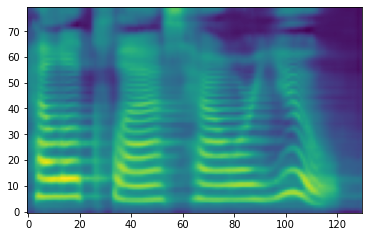

In [ ]:
%matplotlib inline
if spec is not None:
    imshow(spec, origin="lower")
    plt.show()

## Next steps
A demo like this is great for prototyping and experimentation. However, for real production deployment, you would want to use a service like [NVIDIA Riva](https://developer.nvidia.com/riva).

**NeMo is built for training.** You can fine-tune, or train from scratch on your data all models used in this example. We recommend you checkout the following, more in-depth, tutorials next:

* [NeMo fundamentals](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/00_NeMo_Primer.ipynb)
* [NeMo models](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/01_NeMo_Models.ipynb)
* [Speech Recognition](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/asr/ASR_with_NeMo.ipynb)
* [Punctuation and Capitalization](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/nlp/Punctuation_and_Capitalization.ipynb)
* [Speech Synthesis](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/tts/Inference_ModelSelect.ipynb)


You can find scripts for training and fine-tuning ASR, NLP and TTS models [here](https://github.com/NVIDIA/NeMo/tree/main/examples). 

In [ ]:

TTS Inference Model Selection
This notebook can be used to generate audio samples using either NeMo's pretrained models or after training NeMo TTS models. This notebook supports all TTS models and is intended to showcase different models and how their results differ.

That's it folks! Head over to NeMo GitHub for more examples: https://github.com/NVIDIA/NeMo